## 루브릭  
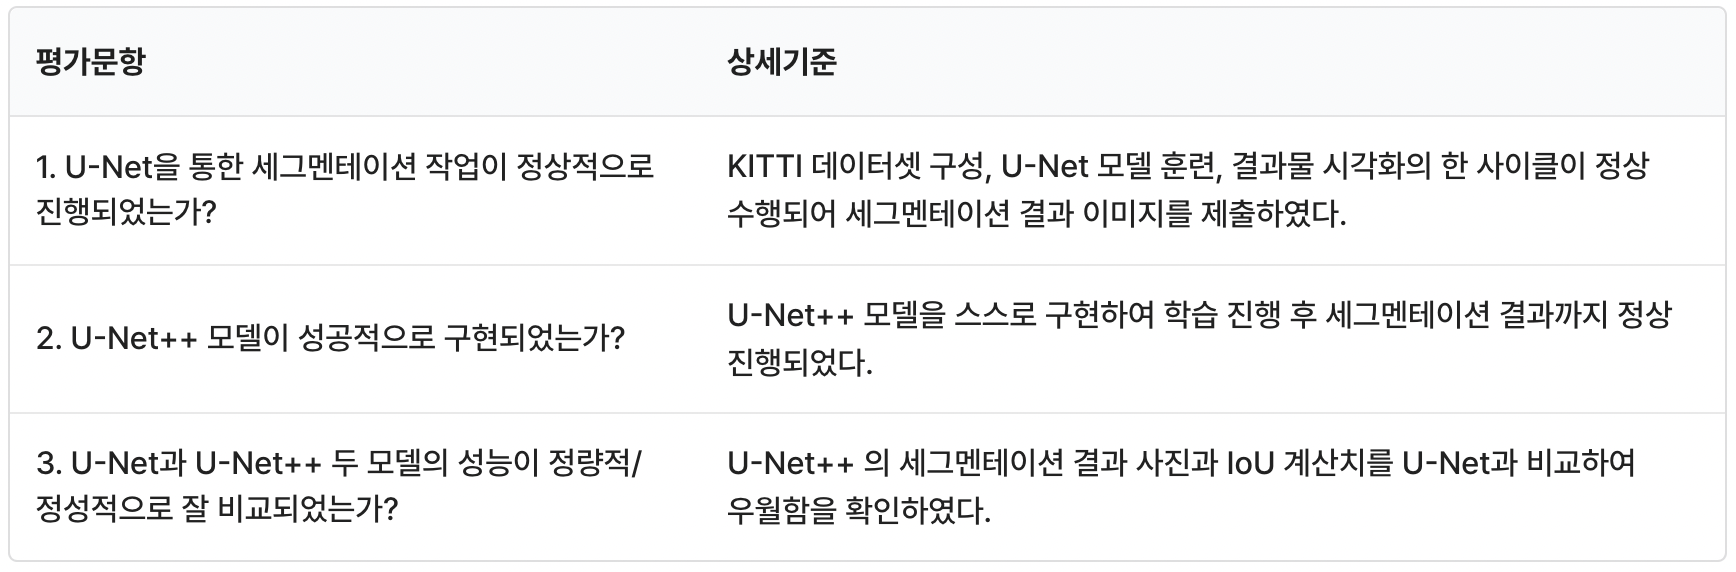

## (1) 데이터 로딩 및 전처리

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                        Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                    Resize(
                    width=224,
                    height=224
                    )
                ])

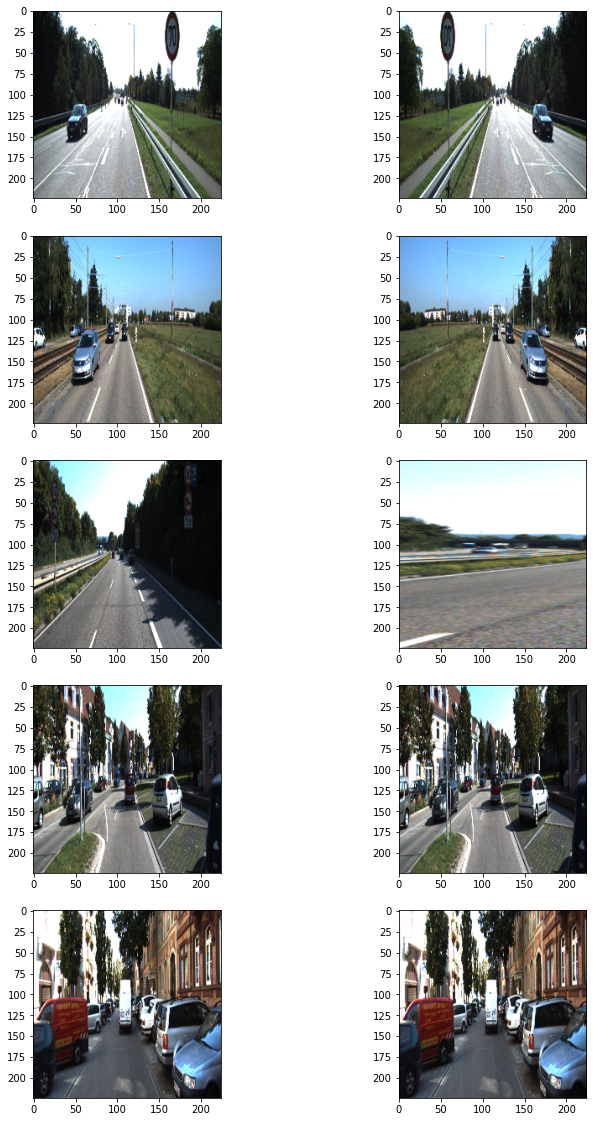

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequence를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## (2) U-Net 모델 구성 및 학습

[U-Net 구조]  
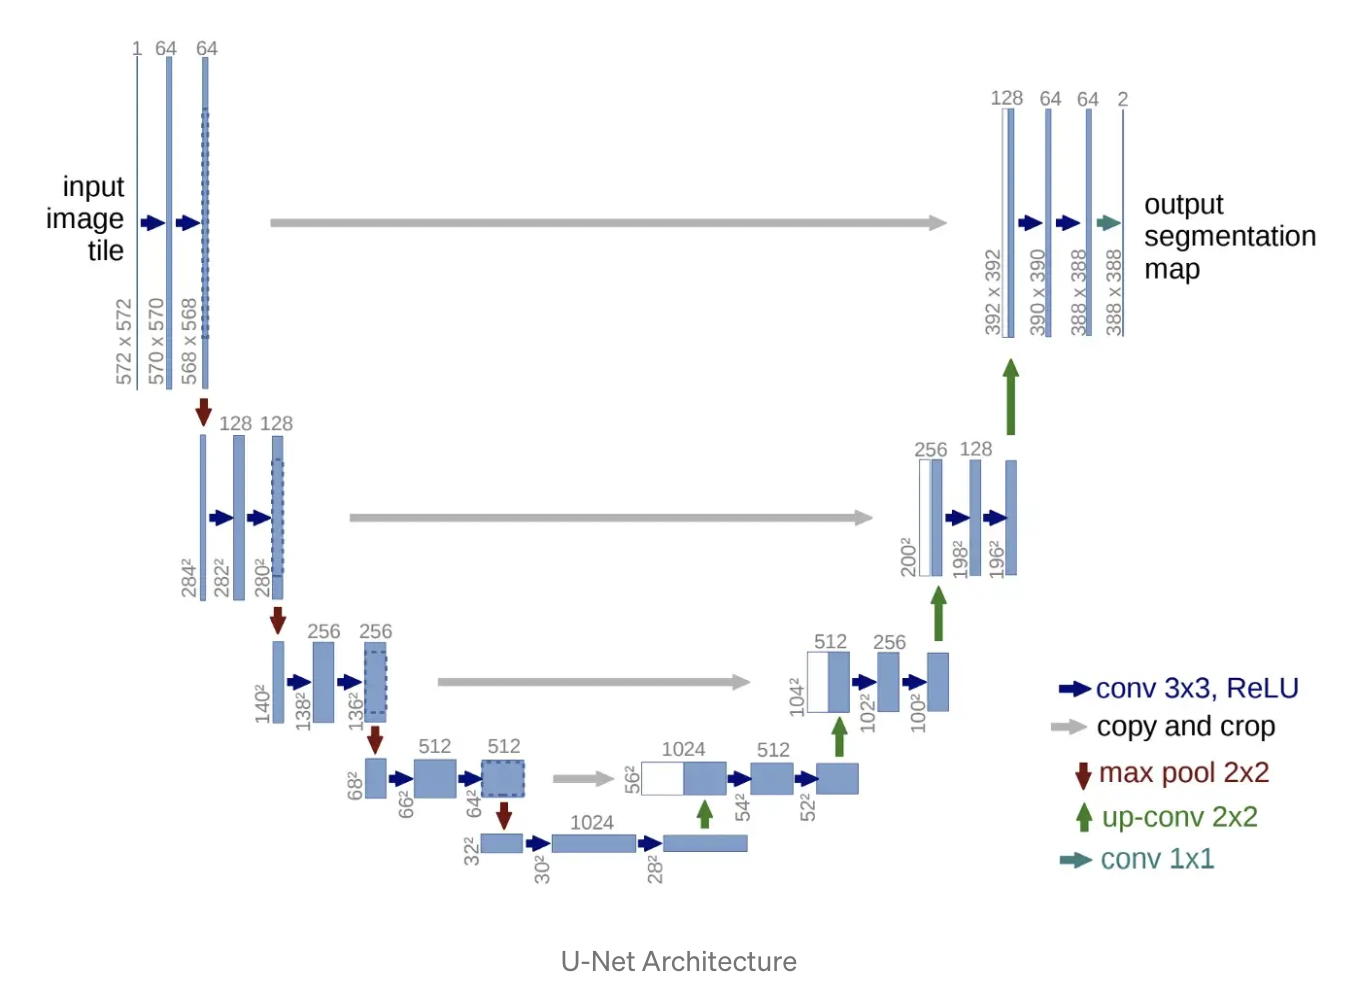

In [6]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

In [7]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

In [8]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
EPOCHS = 50

In [10]:
model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
history_model = model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=EPOCHS,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/50
43/43 [==============================] - 18s 208ms/step - loss: 0.4645 - val_loss: 0.1296
Epoch 2/50
43/43 [==============================] - 9s 198ms/step - loss: 0.1174 - val_loss: 0.1216
Epoch 3/50
43/43 [==============================] - 9s 200ms/step - loss: 0.0999 - val_loss: 0.1003
Epoch 4/50
43/43 [==============================] - 9s 202ms/step - loss: 0.0796 - val_loss: 0.0878
Epoch 5/50
43/43 [==============================] - 9s 203ms/step - loss: 0.0771 - val_loss: 0.0781
Epoch 6/50
43/43 [==============================] - 9s 201ms/step - loss: 0.0801 - val_loss: 0.0795
Epoch 7/50
43/43 [==============================] - 9s 199ms/step - loss: 0.0753 - val_loss: 0.0734
Epoch 8/50
43/43 [==============================] - 9s 198ms/step - loss: 0.0689 - val_loss: 0.0745
Epoch 9/50
43/43 [==============================] - 9s 199ms/step - loss: 0.0662 - val_loss: 0.0678
Epoch 10/50
43/43 [==============================] - 9s 199ms/step - loss: 0.0679 - val_loss: 0.070

In [11]:
import pandas as pd

In [12]:
hist_model = pd.DataFrame(history_model.history) 
hist_model_csv_file = 'history_model.csv'
with open(hist_model_csv_file, mode='w') as f:
    hist_model.to_csv(f)

In [13]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [14]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

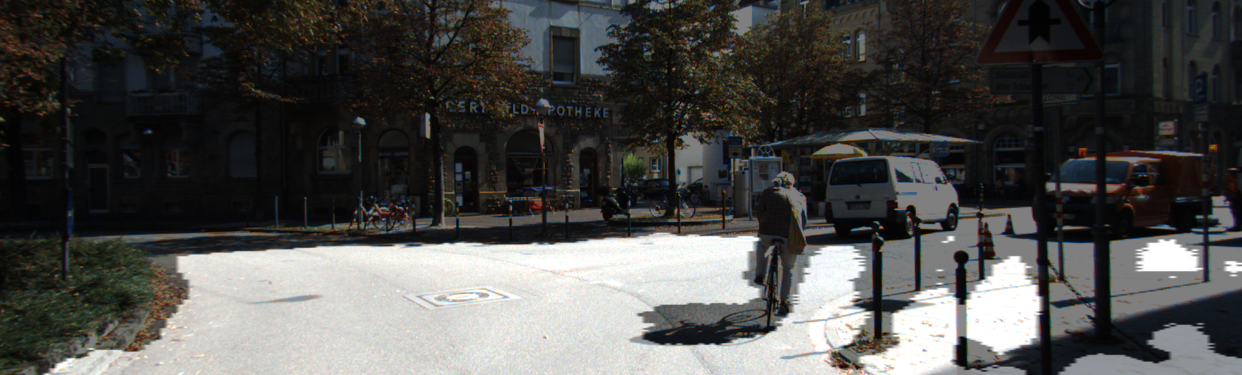

IoU : 0.650221


0.6502211891729774

In [43]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 3    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

## (3) U-Net++ 모델 구성 및 학습

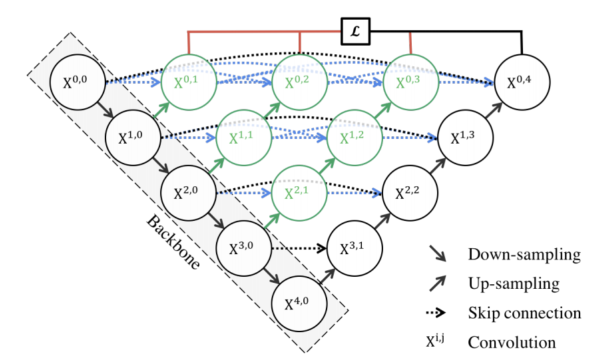

In [16]:
from keras.layers import Conv2DTranspose
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Concatenate
from keras.models import Model

In [17]:
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):
    act = 'relu'
    dropout_rate = 0.5

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same')(input_tensor)
#     x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same')(x)
#     x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x

In [18]:
def UNetPlusPlus(input_shape=(224, 224, 3), num_class=1, deep_supervision=False):
    
    img_input = Input(input_shape, name='main_input')
    
    nb_filter = [64,128,256,512,1024]

    bn_axis = 3

    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same')(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same')(conv1_5)

    if deep_supervision:
        model = Model(inputs=img_input, outputs=[nestnet_output_1,
                                               nestnet_output_2,
                                               nestnet_output_3,
                                               nestnet_output_4])
    else:
        model = Model(inputs=img_input, outputs=[nestnet_output_4])

    return model


### deep_supervision=False, loss = binary_crossentropy 로 학습

In [19]:
model_unetpp_NDS = UNetPlusPlus(input_shape=(224,224,3))

In [20]:
model_unetpp_NDS.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv11_1 (Conv2D)               (None, 224, 224, 64) 1792        main_input[0][0]                 
__________________________________________________________________________________________________
conv11_2 (Conv2D)               (None, 224, 224, 64) 36928       conv11_1[0][0]                   
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 112, 112, 64) 0           conv11_2[0][0]                   
____________________________________________________________________________________________

In [21]:
from keras import backend as K
import keras

# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.int32)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [22]:
model_unetpp_NDS.compile(
    optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy')

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [23]:
history_unetpp_NDS = model_unetpp_NDS.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    verbose=1,
    use_multiprocessing=True,
)
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetpp_nds.h5'
model_unetpp_NDS.save(model_path)

Epoch 1/50
43/43 [==============================] - 29s 485ms/step - loss: 0.4513 - val_loss: 0.1088
Epoch 2/50
43/43 [==============================] - 20s 463ms/step - loss: 0.1134 - val_loss: 0.1537
Epoch 3/50
43/43 [==============================] - 20s 469ms/step - loss: 0.1028 - val_loss: 0.0959
Epoch 4/50
43/43 [==============================] - 20s 460ms/step - loss: 0.0932 - val_loss: 0.0928
Epoch 5/50
43/43 [==============================] - 20s 461ms/step - loss: 0.0772 - val_loss: 0.0790
Epoch 6/50
43/43 [==============================] - 20s 461ms/step - loss: 0.0701 - val_loss: 0.0758
Epoch 7/50
43/43 [==============================] - 20s 460ms/step - loss: 0.0629 - val_loss: 0.0593
Epoch 8/50
43/43 [==============================] - 20s 459ms/step - loss: 0.0621 - val_loss: 0.0740
Epoch 9/50
43/43 [==============================] - 20s 459ms/step - loss: 0.0519 - val_loss: 0.0824
Epoch 10/50
43/43 [==============================] - 20s 458ms/step - loss: 0.0522 - val_lo

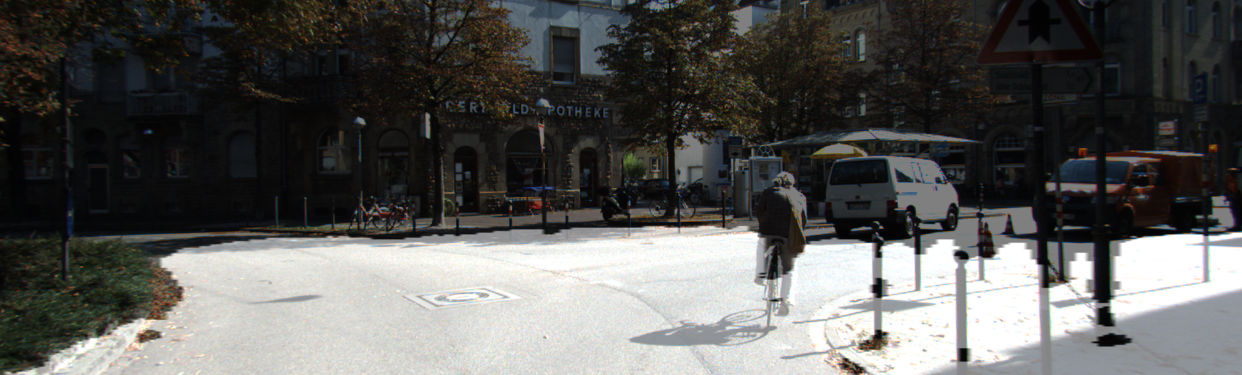

IoU : 0.595423


0.5954225771844082

In [44]:
i = 3
output, prediction, target = get_output(
     model_unetpp_NDS, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

In [25]:
hist_unetpp_NDS_df = pd.DataFrame(history_unetpp_NDS.history) 
hist_unetpp_NDS_csv_file = 'history_unetpp_NDS.csv'
with open(hist_unetpp_NDS_csv_file, mode='w') as f:
    hist_unetpp_NDS_df.to_csv(f)

### deep_supervision=False, loss = binary_crossentropy with dice coef 로 테스트

In [26]:
model_unetpp_NDS_dice = UNetPlusPlus(input_shape=(224,224,3))

In [27]:
model_unetpp_NDS_dice.compile(optimizer="Adam", 
              loss=bce_dice_loss, 
              metrics=["binary_crossentropy", dice_coef])

In [29]:
history_unetpp_NDS_dice = model_unetpp_NDS_dice.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    verbose=1,
    use_multiprocessing=True,
)
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetpp_nds_dice.h5'
model_unetpp_NDS_dice.save(model_path)

Epoch 1/50
43/43 [==============================] - 19s 444ms/step - loss: 0.4712 - binary_crossentropy: 1.0356 - dice_coef: 0.0466 - val_loss: 0.4977 - val_binary_crossentropy: 0.9955 - val_dice_coef: 8.1624e-05
Epoch 2/50
43/43 [==============================] - 20s 451ms/step - loss: 0.3755 - binary_crossentropy: 0.8907 - dice_coef: 0.0699 - val_loss: 0.4977 - val_binary_crossentropy: 0.9955 - val_dice_coef: 8.1624e-05
Epoch 3/50
43/43 [==============================] - 19s 442ms/step - loss: 0.3946 - binary_crossentropy: 0.8826 - dice_coef: 0.0467 - val_loss: 0.4977 - val_binary_crossentropy: 0.9955 - val_dice_coef: 8.1624e-05
Epoch 4/50
43/43 [==============================] - 19s 442ms/step - loss: 0.4103 - binary_crossentropy: 0.9604 - dice_coef: 0.0699 - val_loss: 0.4977 - val_binary_crossentropy: 0.9955 - val_dice_coef: 8.1624e-05
Epoch 5/50
43/43 [==============================] - 19s 443ms/step - loss: 0.3217 - binary_crossentropy: 0.8764 - dice_coef: 0.1165 - val_loss: 0.49

In [30]:
hist_unetpp_NDS_dice_df = pd.DataFrame(history_unetpp_NDS_dice.history) 
hist_unetpp_NDS_dice_csv_file = 'history_unetpp_NDS_dice.csv'
with open(hist_unetpp_NDS_dice_csv_file, mode='w') as f:
    hist_unetpp_NDS_dice_df.to_csv(f)

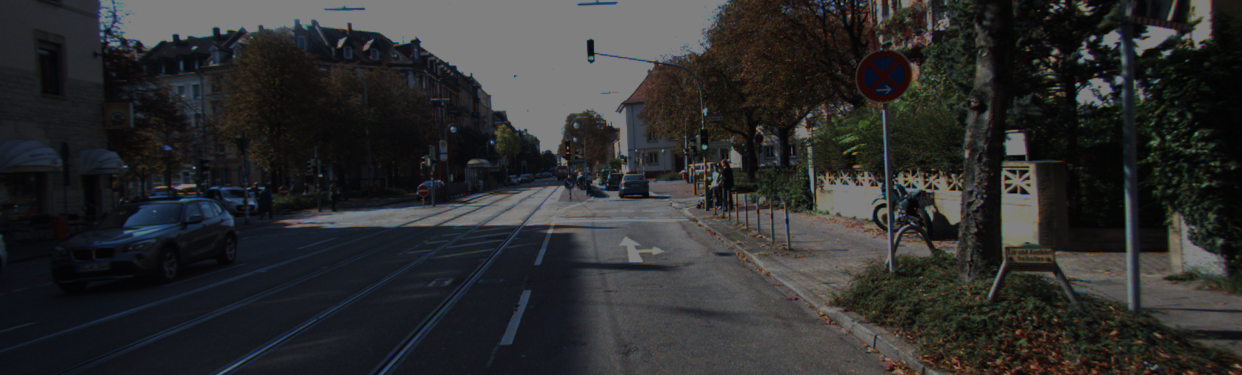

IoU : 0.000000


0.0

In [35]:
i = 1
output, prediction, target = get_output(
     model_unetpp_NDS_dice, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

### deep_supervision=True, loss = binary_crossentropy 로 테스트

In [32]:
model_unetpp_DS = UNetPlusPlus(input_shape=(224,224,3), deep_supervision=True)

In [33]:
model_unetpp_DS.compile(
    optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy')

In [34]:
history_unetpp_DS = model_unetpp_DS.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    verbose=1,
    use_multiprocessing=True,
)
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetpp_ds.h5'


Epoch 1/50
43/43 [==============================] - 24s 495ms/step - loss: 2.2436 - output_1_loss: 0.6608 - output_2_loss: 0.5822 - output_3_loss: 0.5296 - output_4_loss: 0.4710 - val_loss: 1.2555 - val_output_1_loss: 0.6055 - val_output_2_loss: 0.1824 - val_output_3_loss: 0.2040 - val_output_4_loss: 0.2636
Epoch 2/50
43/43 [==============================] - 21s 474ms/step - loss: 0.8025 - output_1_loss: 0.3625 - output_2_loss: 0.1418 - output_3_loss: 0.1476 - output_4_loss: 0.1506 - val_loss: 0.4678 - val_output_1_loss: 0.1382 - val_output_2_loss: 0.1143 - val_output_3_loss: 0.1093 - val_output_4_loss: 0.1059
Epoch 3/50
43/43 [==============================] - 20s 468ms/step - loss: 0.4567 - output_1_loss: 0.1216 - output_2_loss: 0.1122 - output_3_loss: 0.1107 - output_4_loss: 0.1122 - val_loss: 0.4086 - val_output_1_loss: 0.1105 - val_output_2_loss: 0.1012 - val_output_3_loss: 0.0993 - val_output_4_loss: 0.0977
Epoch 4/50
43/43 [==============================] - 20s 465ms/step - loss

AttributeError: 'History' object has no attribute 'save'

In [36]:
model_unetpp_DS.save(model_path)

In [37]:
hist_unetpp_DS_df = pd.DataFrame(history_unetpp_DS.history) 
hist_unetpp_DS_csv_file = 'history_unetpp_DS.csv'
with open(hist_unetpp_DS_csv_file, mode='w') as f:
    hist_unetpp_DS_df.to_csv(f)

In [38]:
i = 3
output, prediction, target = get_output(
     model_unetpp_DS, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

TypeError: Cannot handle this data type: (1, 1, 224), |u1

In [39]:
history_unet =  pd.read_csv("history_model.csv")
history_unetplusplus =  pd.read_csv("history_unetpp_NDS.csv")

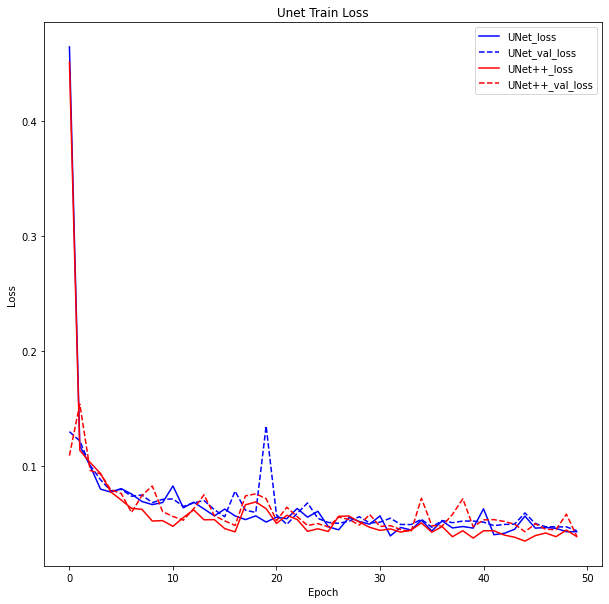

In [40]:
fig = plt.figure(figsize = (10, 10))

plt.plot(history_unet['loss'], 'b')
plt.plot(history_unet['val_loss'], 'b--')
plt.plot(history_unetplusplus['loss'], 'r')
plt.plot(history_unetplusplus['val_loss'], 'r--')

plt.title('Unet Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['UNet_loss', 'UNet_val_loss', 'UNet++_loss', 'UNet++_val_loss' ])


## 회고  
- UNet++ 모델을 구성하여 테스트 했으나, 안타깝게도 UNet 모델 대비 결과가 좋지 않았습니다.   
- 추가로 UNet++ 모델 loss 조건으로 binary_crossentropy와 binary_crossentropy with dice_coef를 비교하여 적용해 보았으나, binary_crossentropy with dice_coef를 사용했을 때는 학습이 정상적으로 이루어지지지 않은 것으로 판단되어 추가적인 검증이 필요합니다.   
- 또한 마지막 한층만의 loss만을 사용하지 않고 마지막 4층의 loss를 활용한 조건 (deep_supervision=True)도 활용해 봤으나, 정상적인 실행이 불가능해서 추가적인 디버깅이 필요합니다.   
- 이상하게도 개선 모델을 테스트할 때 계산 결과를 제대로 도출하지 못하는 현상이 반복적으로 발생하고 있습니다. 모델 자체에 대한 디버깅 및 검증을 추가적으로 더 꼼꼼히 수행할 필요성이 있습니다. 
- 추가 테스트를 수행하여, 기존 UNet++ 모델에서 dropout부분을 제외하고 학습을 시킨 결과 loss가 UNet 대비 일부 줄어드는 것을 확인할 수 있었느나 IOU 값은 여전히 낮아 추가적인 개선 작업이 필요할 것 같습니다.

[참고]  
1. Unet++ 코드   
https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/helper_functions.py#L37  
https://github.com/qsdcfd/AIFFEL/blob/TIL/Personal-Project/Going%20Deeper%20(CV)/Going%20Deeper%2005/GD10%5Dsemantic%20segmentation.Sehyun.ipynb